In [1]:
import pandas as pd
import numpy as np
import joblib
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     D:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
stop_words = set(stopwords.words('english'))
domain_words = {
    "airport","klia","staff","malaysia","malaysian","flight","terminal","gate","counter",
    "immigration","airline","airlines","plane","arrival","departure","queue","checkin",
    "baggage","luggage"
}
stop_words.update(domain_words)

In [5]:
lemmatizer = WordNetLemmatizer()

def get_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return " ".join([
        lemmatizer.lemmatize(word, get_pos(tag))
        for word, tag in pos_tags
        if word not in stop_words
    ])


In [6]:
# Load cleaned training data
df = pd.read_csv("cleaned_training_data.csv")
X = df['processed_text'].astype(str)
y = df['SENTIMENT'].astype(str)

In [7]:
# Train-test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [8]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [9]:
# Train LinearSVC
svm = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
svm.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


In [10]:
# Evaluate
y_pred = svm.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=4))

Test Accuracy: 0.8745
              precision    recall  f1-score   support

    Negative     0.8849    0.9373    0.9103       287
     Neutral     1.0000    0.3030    0.4651        33
    Positive     0.8529    0.8788    0.8657       198

    accuracy                         0.8745       518
   macro avg     0.9126    0.7064    0.7470       518
weighted avg     0.8800    0.8745    0.8649       518



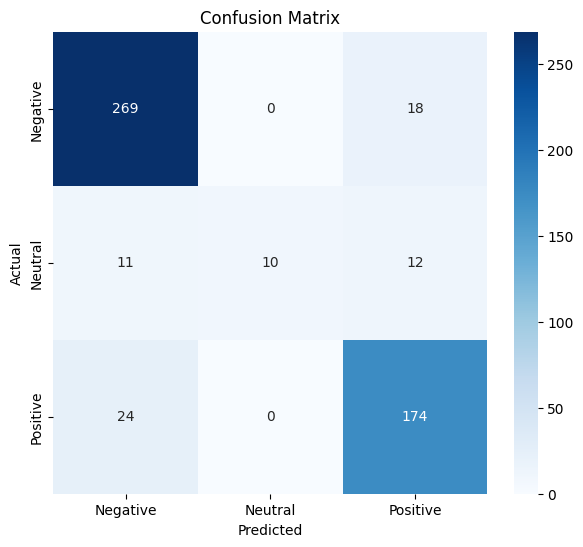

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
cm_df = pd.DataFrame(cm, index=sorted(y.unique()), columns=sorted(y.unique()))
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [12]:
# Hyperparameter tuning (GridSearchCV)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LinearSVC(random_state=RANDOM_STATE, max_iter=10000),
                    param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

best_svm = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred_grid = best_svm.predict(X_test_tfidf)
print("Accuracy with best estimator:", accuracy_score(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))


Best params: {'C': 1}
Best CV score: 0.8530380940193387
Accuracy with best estimator: 0.8745173745173745
              precision    recall  f1-score   support

    Negative       0.88      0.94      0.91       287
     Neutral       1.00      0.30      0.47        33
    Positive       0.85      0.88      0.87       198

    accuracy                           0.87       518
   macro avg       0.91      0.71      0.75       518
weighted avg       0.88      0.87      0.86       518



In [13]:
# Save TF-IDF & Tuned SVM
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(best_svm, "svm_model_tuned.pkl")
print("Saved tfidf_vectorizer.pkl and svm_model_tuned.pkl")

Saved tfidf_vectorizer.pkl and svm_model_tuned.pkl


In [14]:
# Predict unlabeled data
UNLABELED_FILE = "unlabeled_real_data.csv"
df_unlabeled = pd.read_csv(UNLABELED_FILE)
tqdm.pandas()
df_unlabeled['processed_text'] = df_unlabeled['TEXT'].progress_apply(preprocess_text)

X_tfidf_unlabeled = tfidf.transform(df_unlabeled['processed_text'].astype(str))
preds = best_svm.predict(X_tfidf_unlabeled)

100%|██████████| 103/103 [00:03<00:00, 33.71it/s]


In [15]:
decision = best_svm.decision_function(X_tfidf_unlabeled)
if len(decision.shape) == 1:
    # Binary
    probs_pos = 1 / (1 + np.exp(-decision))
    probs = np.vstack([1-probs_pos, probs_pos]).T
else:
    e_x = np.exp(decision - np.max(decision, axis=1, keepdims=True))
    probs = e_x / np.sum(e_x, axis=1, keepdims=True)

df_unlabeled['PREDICTED_SENTIMENT'] = preds
df_unlabeled['CONFIDENCE'] = probs.max(axis=1)

OUTFILE = "unlabeled_predictions.csv"
df_unlabeled.to_csv(OUTFILE, index=False)
print(f"Saved {OUTFILE} — {len(df_unlabeled)} rows")

Saved unlabeled_predictions.csv — 103 rows
